In [1]:
import os
import sys

REPO_DIRECTORY = f"{os.getcwd()}/../.."
sys.path.append(REPO_DIRECTORY)

In [78]:
import coconut
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import transformers
import tqdm

In [3]:
MODEL_ARCHITECTURE = "openai-community/gpt2"
COCONUT_CHECKPOINT = "./checkpoints/gsm-coconut/checkpoint_4"
DATA_DIRECTORY = "./data/chains-of-thoughts/openai-community/gpt2/checkpoint_15.pkl"
GPU_ID = 0
MAX_NEW_TOKENS = 100
N_SEQUENCES = 15

In [4]:
model = transformers.AutoModelForCausalLM.from_pretrained(MODEL_ARCHITECTURE)
tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_ARCHITECTURE)
tokenizer.pad_token = tokenizer.eos_token

coconut_tokens = ["<|latent|>", "<|start-latent|>", "<|end-latent|>"]
tokenizer.add_tokens(coconut_tokens)
token_ids = tokenizer.convert_tokens_to_ids(coconut_tokens)

model.resize_token_embeddings(len(tokenizer))
embeddings = model.get_input_embeddings()
target_id = tokenizer.convert_tokens_to_ids("<<")

for token_id in token_ids:
    target_embedding = embeddings.weight.data[token_id]
    embeddings.weight.data[token_id] = target_embedding

model = coconut.Coconut(model, *token_ids, tokenizer.eos_token_id)

checkpoint = f"{REPO_DIRECTORY}/{COCONUT_CHECKPOINT}"
weights = torch.load(checkpoint, torch.device(GPU_ID), weights_only=False)
model.load_state_dict(weights, strict=False)
_ = model.to(GPU_ID)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [5]:
def coconut_next_token_distribution(
    model: coconut.Coconut,
    input_ids: torch.Tensor,
    **kwargs,
) -> torch.Tensor:
    gen_fwd_cnt = 0

    assert input_ids.shape[0] == 1, "only support batch_size == 1 now"

    outputs = model.forward(
        input_ids,
        torch.ones_like(input_ids, device=input_ids.device),
        input_ids.clone(),
        torch.arange(
            0, input_ids.shape[1], dtype=torch.long, device=input_ids.device
        ).reshape(1, -1),
        **kwargs,
    )

    return torch.nn.functional.softmax(outputs.logits[:, -1], dim=1)

In [11]:
NUM_LATENTS = 1


df = pd.read_pickle(f"{DATA_DIRECTORY}")
test_df = df.iloc[0:20]

results = {True: [], False: []}

for _, entry in test_df.iterrows():
    question = entry["Question"] + "<|start-latent|>" + "<|latent|>" * NUM_LATENTS + "<|end-latent|>"
    following_rationales = "\n".join(entry["Target Rationales"].split("\n")[1:])

    tokenized_question = tokenizer(question, return_tensors="pt").to(GPU_ID)
    target_sequence = tokenizer(question + following_rationales, return_tensors="pt").to(GPU_ID)


    product_of_probabilities = 1
    counter = tokenized_question["input_ids"].shape[-1]
    while counter < target_sequence["input_ids"].shape[-1] - 1:

        input_tokens = torch.stack([target_sequence["input_ids"][0][:counter]])
        label = target_sequence["input_ids"][0][counter + 1]

        distribution = coconut_next_token_distribution(
            model,
            input_tokens,
        )


        probability = float(distribution[0][int(float(label))])

        product_of_probabilities *= probability

        counter += 1

    
    results[entry["Correct"]] += [product_of_probabilities]

    
for key, val in results.items():
    print(key, np.mean(val), np.std(val))

True 6.221811786180366e-38 3.935019176781045e-38
False 1.6864593418258184e-45 3.111507638930571e-61


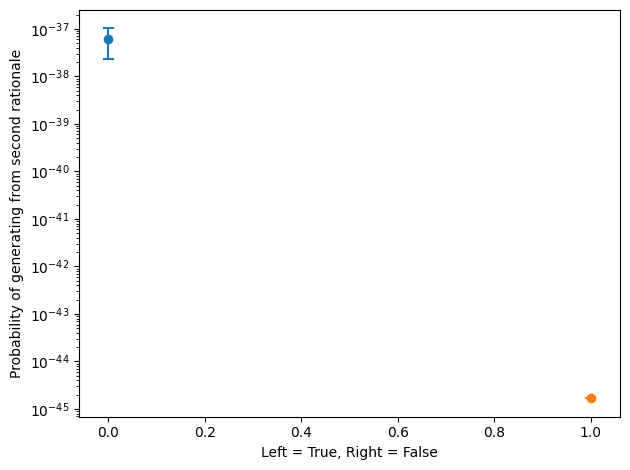

In [13]:
for i, (key, val) in enumerate(results.items()):

    mean, stdv = np.mean(val), np.std(val)
    lower = mean - stdv
    upper = mean + stdv

    plt.plot([i, i], [lower, upper], color=f"C{i}")
    plt.plot([i - 0.01, i + 0.01], [lower, lower], color=f"C{i}")
    plt.plot([i - 0.01, i + 0.01], [upper, upper], color=f"C{i}")
    plt.scatter([i], [mean], color=f"C{i}")

    plt.xlabel("Left = True, Right = False")
    plt.ylabel("Probability of generating from second rationale")


plt.semilogy()
plt.tight_layout()
plt.savefig("figures/2025-01-28-tuesday-evening.png")

In [111]:
NUM_LATENTS = 1

df = pd.read_pickle(f"{DATA_DIRECTORY}")
# results = {i: {} for i in [True, False]}
# max_results = {}

for _, entry in tqdm.tqdm([*df.iterrows()]):
    question = entry["Question"] + "<|start-latent|>" + "<|latent|>" * NUM_LATENTS + "<|end-latent|>"
    target = question + "\n".join(entry["Target Rationales"].split("\n")[NUM_LATENTS:])
    target += "\n###" + entry["Answer"]

    input_sequence = tokenizer(question, return_tensors="pt").to(GPU_ID)["input_ids"].squeeze()
    target_sequence = tokenizer(target, return_tensors="pt").to(GPU_ID)["input_ids"].squeeze()

    product, max_product, counter = 1, 1, 1
    for token_id in range(len(input_sequence), len(target_sequence)):
        distribution = coconut_next_token_distribution(
            model, 
            torch.stack([target_sequence[:token_id]]),
        ).squeeze().cpu().detach().numpy()
        
        label_token = target_sequence[token_id]
        product *= distribution[int(label_token)]

        print(product)

        max_product *= max(distribution)

        # print(tokenizer.decode([label_token]), product)

        # results[entry["Correct"]][counter] = results_2[entry["Correct"]].get(counter, []) + [product]
        # max_results[counter] = max_results.get(counter, []) + [max_product]

        counter += 1

        # results[entry["Correct"]][tokens_to_predict] += [product]

    break


# for i, (key, val) in enumerate(results.items()):

#     mean, stdv = np.mean(val), np.std(val)
#     lower = mean - stdv
#     upper = mean + stdv

#     plt.plot([i, i], [lower, upper], color=f"C{i}")
#     plt.plot([i - 0.01, i + 0.01], [lower, lower], color=f"C{i}")
#     plt.plot([i - 0.01, i + 0.01], [upper, upper], color=f"C{i}")
#     plt.scatter([i], [mean], color=f"C{i}")

#     plt.xlabel("Left = True, Right = False")
#     plt.ylabel("Probability of generating from second rationale")


# plt.semilogy()

# plt.tight_layout()

  0%|          | 0/5349 [00:00<?, ?it/s]

0.9598124
0.009912155
0.00668293
0.0038767925
0.0038733205
0.003873309
0.0038567553
0.0038567553
0.0021438452
4.69696e-10


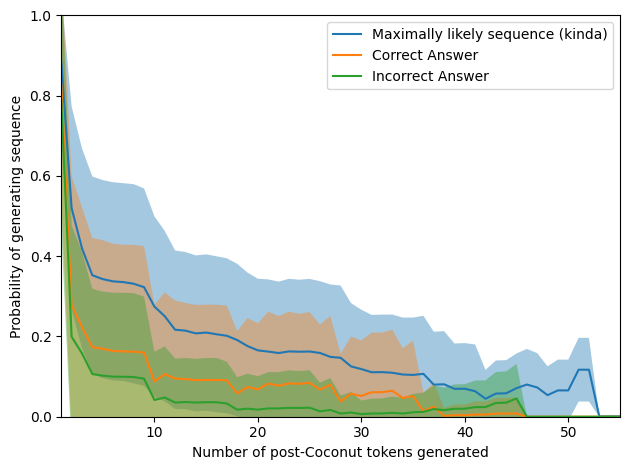

In [119]:
sample = None

x, mean, lower, upper = [], [], [], []
for tokens_to_predict, vals in max_results.items():
    x += [tokens_to_predict]
    if sample is not None:
        mean += [np.mean(vals[sample])]
        lower += [np.mean(vals[sample]) - np.std(vals[sample])]
        upper += [np.mean(vals[sample]) + np.std(vals[sample])]
    else:
        mean += [np.mean(vals)]
        lower += [np.mean(vals) - np.std(vals)]
        upper += [np.mean(vals) + np.std(vals)]

plt.fill_between(x, lower, upper, alpha=0.4, linewidth=0)
plt.plot(x, mean, label="Maximally likely sequence (kinda)")


for i in [True, False]:
    x, mean, lower, upper = [], [], [], []
    for tokens_to_predict, vals in results[i].items():
        x += [tokens_to_predict]
        if sample is not None:
            mean += [np.mean(vals[sample])]
            lower += [np.mean(vals[sample]) - np.std(vals[sample])]
            upper += [np.mean(vals[sample]) + np.std(vals[sample])]
        else:
            mean += [np.mean(vals)]
            lower += [np.mean(vals) - np.std(vals)]
            upper += [np.mean(vals) + np.std(vals)]
    # print(mean)
    
    plt.fill_between(x, lower, upper, alpha=0.4, linewidth=0)
    plt.plot(x, mean, label="Correct Answer" if i else "Incorrect Answer")
    # plt.scatter(x, mean)




plt.legend()
plt.xlim([1, 55])
plt.ylim([10 ** -13, 1])
plt.ylabel("Probability of generating sequence")
plt.xlabel("Number of post-Coconut tokens generated")
# plt.semilogy()
plt.tight_layout()



Correct/incorrect:

$P(x_1 | C) \times P(x_2 | C, x_1) \times ... \times P(x_n | C, x_1, x_2, ..., x_{n-1})$

Maximally likely sequence (kinda):

$\max(P(x | C)) \times \max(P(x | C, x_1)) \times ... \times \max(P(x | C, x_1, x_2, ..., x_{n_1}))$